#  XGB Model

In [1]:
import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
'''for implementing simple logisticregression'''
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
'''for saving models'''
from joblib import dump

In [2]:
# MANIFEST - list of versions on board 
import sys
import os
print(pd.datetime.now())
print('OS: '+os.uname().sysname)
print('Python: '+sys.version)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
print('sklearn: '+sklearn.__version__)

2020-01-22 11:33:32.159245
OS: Linux
Python: 3.6.7 | packaged by conda-forge | (default, Nov  6 2019, 16:19:42) 
[GCC 7.3.0]
numpy: 1.17.3
pandas: 0.25.3
sklearn: 0.22.1


## Data Prep

In [3]:
train_file = 'train_234.csv.gz'
data = pd.read_csv(train_file,low_memory = False)
data.shape

In [34]:
date_cols = [c for c in data.columns if 'days' in c]

for c in date_cols:
    data[c] = pd.to_timedelta(data[c]).dt.days
    
data.visit_duration = pd.to_timedelta(data.visit_duration).dt.days

In [46]:
data.race_concept_name.unique()

array([5, 6, 3, 4, 2, 1, 0])

In [45]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data.race_concept_name = data.race_concept_name.replace(to_replace=0, value='Unknown')
data.race_concept_name = data.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(data.race_concept_name)
data.race_concept_name = label_encoder.transform(data.race_concept_name)

In [61]:
data = data.fillna(0)
X = data.drop(['death_in_next_window','person_id'], axis = 1)
features = X.columns.values
y = data[['death_in_next_window']]
X = np.array(X)
y = np.array(data[['death_in_next_window']]).ravel()

## LR Model

In [53]:
%%time
clf = LogisticRegressionCV(cv = 3, penalty = 'l2', tol = 0.0001, fit_intercept = True, intercept_scaling = 1, class_weight = None, random_state = None,
max_iter = 100, verbose = 0, n_jobs = None).fit(X,y)
print("Training stage finished", flush = True)

Training stage finished


In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

y_scores = clf.predict_proba(X)[:,1]
roc_auc_score(y, y_scores)

0.5158904187607435

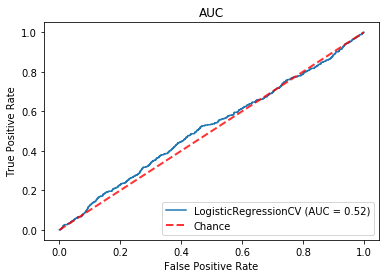

In [55]:
#from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

fig, ax = plt.subplots()
plot_roc_curve(clf, X, y, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="AUC")
ax.legend(loc="lower right")
plt.show()

In [56]:
# https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap
# https://github.com/scikit-learn/scikit-learn/issues/5992

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y, y_scores)
print('PRAUC = ', average_precision)

PRAUC =  0.0021206718233540466


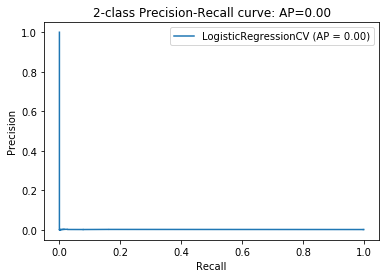

In [57]:
precision, recall, thresholds = precision_recall_curve(y, clf.predict(X))

disp = plot_precision_recall_curve(clf, X, y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
disp.ax_.legend(loc="upper right")
plt.show()

## XGB Model

In [58]:
import xgboost as xgb
xgb.__version__

'0.90'

In [65]:
kfold = 3
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=kfold)
skf.get_n_splits(X, y)

3

In [152]:

params = {
    'eval_metric': ['auc', 'error'],
    'tree_method' : 'auto',
    'random_state' : 1234,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 10,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 1.0,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.5,
    'subsample' : 1.0,
    'n_jobs': -1.0,
}

num_round = 1000

[Fold 1/3]


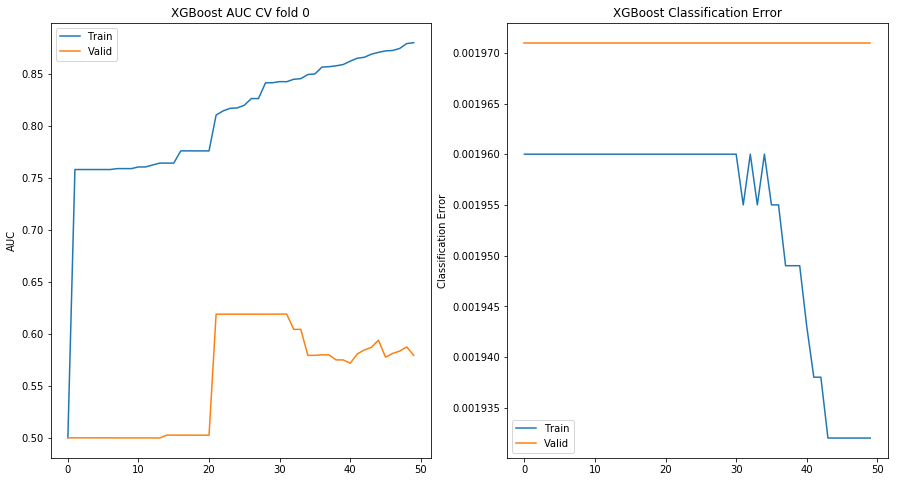

[Fold 1/3 Prediciton:]
[Fold 2/3]


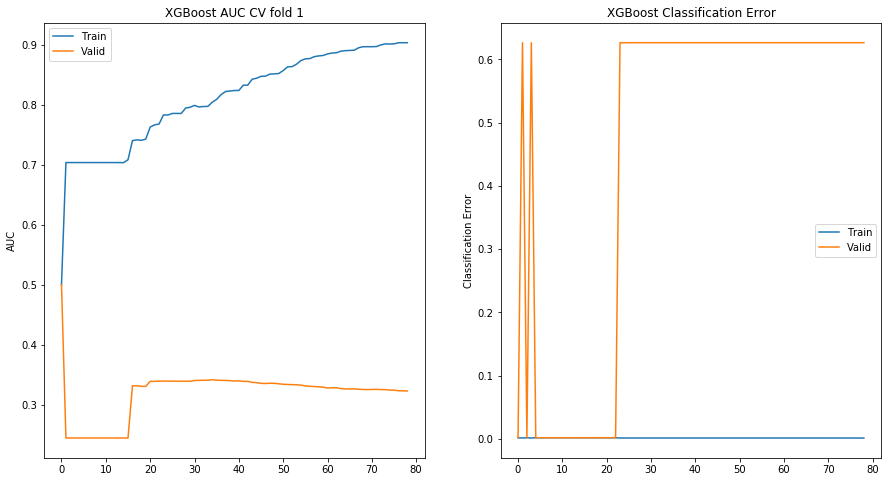

[Fold 2/3 Prediciton:]
[Fold 3/3]


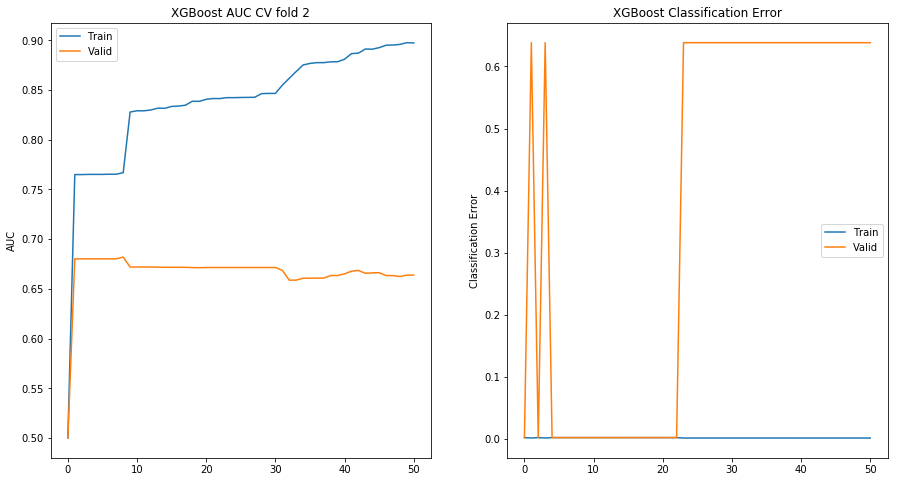

[Fold 3/3 Prediciton:]


In [160]:
df_preds = pd.DataFrame()
evals_result ={}

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    xgb_model = xgb.train(params, d_train, num_round, watchlist, 
                          early_stopping_rounds=50, maximize=True, 
                          evals_result=evals_result, 
                          verbose_eval=False)
    
    # plot learning curve
    epochs = len(evals_result['train']['auc'])
    x_axis = range(0, epochs)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
    ax1.plot(x_axis, evals_result['train']['auc'], label='Train')
    ax1.plot(x_axis, evals_result['valid']['auc'], label='Valid')
    ax1.legend()
    ax1.set_ylabel('AUC')
    ax1.set_title('XGBoost AUC CV fold '+str(i))
    ax2.plot(x_axis, evals_result['train']['error'], label='Train')
    ax2.plot(x_axis, evals_result['valid']['error'], label='Valid')
    ax2.legend()
    ax2.set_ylabel('Classification Error')
    ax2.set_title('XGBoost Classification Error')
    plt.show()

    # Predict on our test data
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    preds = xbg_model.predict(d_valid, ntree_limit=xgb_model.best_ntree_limit)
    df_preds = df_preds.append(list(zip(valid_index, preds)))

In [161]:
df_preds.columns = ['id', 'target']
df_preds = df_preds.set_index('id')
df_preds.head()

,target
id,
0,0.475098
1,0.475098
2,0.475098
3,0.475098
4,0.475098
